In [54]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
import joblib
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from lightgbm import LGBMClassifier
from sklearn.metrics import r2_score,mean_squared_error

In [55]:
df=pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [56]:
df.drop(['CustomerID'], axis=1, inplace=True)

In [57]:
encoder=LabelEncoder()
df['Genre'] = encoder.fit_transform(df['Genre'])

In [58]:
scaler=StandardScaler()
df_scaled = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))           
df_scaled = pd.DataFrame(df, columns=df.select_dtypes(include=['float64', 'int64']).columns)

In [59]:
df_scaled.describe()


,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.440000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,0.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


In [60]:
upper_bound = {}
lower_bound = {}

for col in df_scaled.columns:
    q1 = df_scaled[col].quantile(0.25)
    q3 = df_scaled[col].quantile(0.75)
    iqr = q3 - q1
    upper_bound[col] = q3 + 1.5 * iqr
    lower_bound[col] = q1 - 1.5 * iqr

for col in df_scaled.columns:
    df_scaled = df_scaled[(df_scaled[col] >= lower_bound[col]) & (df_scaled[col] <= upper_bound[col])]

In [61]:
df_scaled.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [62]:
features = df_scaled.drop('Spending Score (1-100)', axis=1)
target = df_scaled['Spending Score (1-100)']

In [63]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)

# Parameter grid for tuning
param_grid = {
    'depth': [3,4,6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200],
    'l2_leaf_reg': [1,7,10]
}

# Grid Search with 5-fold CV
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='r2',
    cv=8,
    verbose=1,
    n_jobs=-1
)

# Train model
grid_search.fit(x_train, y_train)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)


# Metrics
print("✅ Best Parameters:", grid_search.best_params_)
print("📈 Best CV R² Score:", grid_search.best_score_)
print("Test R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))

Fitting 8 folds for each of 72 candidates, totalling 576 fits
✅ Best Parameters: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 10, 'learning_rate': 0.05}
📈 Best CV R² Score: 0.3262794596889753
Test R² Score: 0.37559115354859396
RMSE: 429.4746486777416


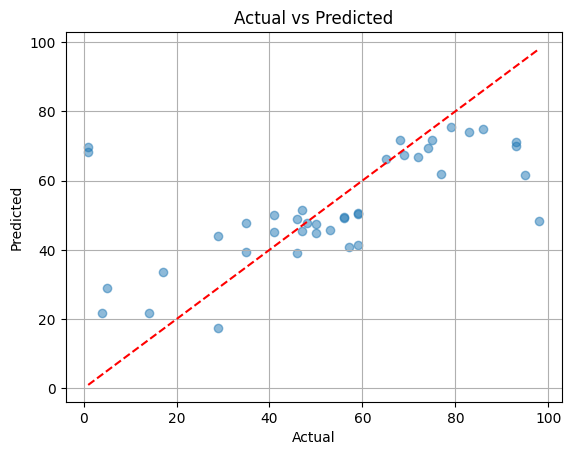

In [65]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()